In [1]:
!pip install kaggle


In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [4]:
!kaggle datasets download -d deathtrooper/eyepacs-airogs-light

 98% 295M/302M [00:03<00:00, 123MB/s]
100% 302M/302M [00:03<00:00, 87.8MB/s]


In [5]:
mkdir 'destination folder'

In [6]:
!unzip "/content/eyepacs-airogs-light.zip" -d "/content/destination folder"


Streaming output truncated to the last 5000 lines.
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-1485.jpg  
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-1486.jpg  
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-1487.jpg  
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-1488.jpg  
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-1489.jpg  
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-149.jpg  
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-1490.jpg  
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-1491.jpg  
  inflating: /content/destination folder/release-raw/release-raw/train/NRG/EyePACS-NRG-1492.jpg  
  inflating: /content/destination folder/release-raw/release-raw/tra

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, MaxPooling2D ,Conv2D, Flatten, GlobalMaxPool2D
from tensorflow.keras.applications import Xception, mobilenet_v3, vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers

In [9]:
img_width, img_height = 299,299
batch_size = 32
num_epochs = 50

In [13]:
testDir = '/content/destination folder/release-crop/release-crop/test'
trainDir = '/content/destination folder/release-crop/release-crop/train'
validDir = '/content/destination folder/release-crop/release-crop/validation'

In [14]:
val_datagen = ImageDataGenerator(rescale = 1. / 255)
train_datagen = ImageDataGenerator(#rotation_range=90,
                                    #brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     #validation_split=0.15,
                                    #preprocessing_function=preprocess_input,
                                    zoom_range=0.15,
                                    fill_mode="constant",
                                    cval=0.1,
                                    rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    directory=trainDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True
)

validation_generator = val_datagen.flow_from_directory(
    directory=validDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)

test_generator =  test_datagen.flow_from_directory(
    testDir,
    batch_size=batch_size,
    class_mode='binary',
    target_size=(img_width, img_height),
    shuffle = False
)

Found 5000 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience = 15,
                               mode='auto',
                               min_delta = 0.001)

base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False,
                                                            input_shape=(img_width, img_height, 3),
                                                            classifier_activation='sigmoid')
base_model.trainable = True
#for layer in base_model.layers[:108]:
#   layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 [==============================] - 1s 0us/step


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stopping],
    verbose = 2
)

Epoch 1/50
157/157 - 191s - loss: 0.5201 - accuracy: 0.7418 - val_loss: 7.0150 - val_accuracy: 0.5056 - lr: 0.0010 - 191s/epoch - 1s/step
Epoch 2/50
157/157 - 142s - loss: 0.4400 - accuracy: 0.7998 - val_loss: 0.7204 - val_accuracy: 0.8000 - lr: 0.0010 - 142s/epoch - 903ms/step
Epoch 3/50
157/157 - 142s - loss: 0.3925 - accuracy: 0.8228 - val_loss: 0.3122 - val_accuracy: 0.8722 - lr: 0.0010 - 142s/epoch - 904ms/step
Epoch 4/50
157/157 - 142s - loss: 0.3606 - accuracy: 0.8410 - val_loss: 0.3963 - val_accuracy: 0.8167 - lr: 0.0010 - 142s/epoch - 905ms/step
Epoch 5/50
157/157 - 142s - loss: 0.3691 - accuracy: 0.8380 - val_loss: 0.6243 - val_accuracy: 0.8500 - lr: 0.0010 - 142s/epoch - 902ms/step
Epoch 6/50
157/157 - 142s - loss: 0.3566 - accuracy: 0.8428 - val_loss: 0.2730 - val_accuracy: 0.8907 - lr: 0.0010 - 142s/epoch - 901ms/step
Epoch 7/50
157/157 - 142s - loss: 0.3447 - accuracy: 0.8536 - val_loss: 0.4473 - val_accuracy: 0.8574 - lr: 0.0010 - 142s/epoch - 901ms/step
Epoch 8/50
157/1

32/32 - 7s - loss: 0.1874 - accuracy: 0.9370 - 7s/epoch - 230ms/step


[0.18744231760501862, 0.9369999766349792]

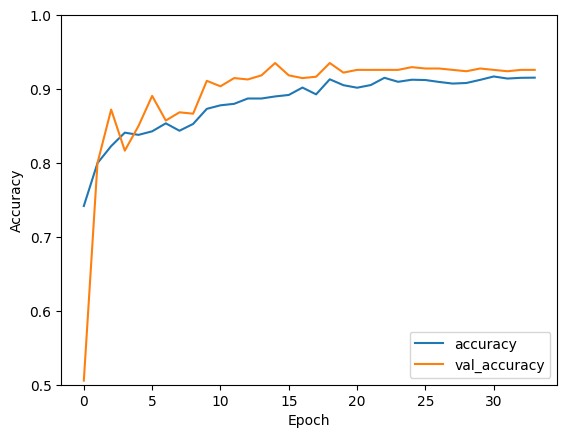

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

model.evaluate(test_generator, verbose=2)